Install required packages

In [1]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ASUS\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Import libraries

In [1]:
import os
import requests
import zipfile,os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display

from tensorflow.keras.applications import InceptionV3

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

%matplotlib inline

Define the paths for training and validation directories

In [2]:
train_dir = r"D:\BANGKIT\CAPSTONE\CODING FITUR 1\Dataset\training"
val_dir = r"D:\BANGKIT\CAPSTONE\CODING FITUR 1\Dataset\validation"

Load the InceptionV3 model

In [3]:
# Load the InceptionV3 model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Set all layers in the InceptionV3 model to be non-trainable
for layer in inception_model.layers:
    layer.trainable = False

Building Classification Model of InceptionV3

In [4]:
model = Sequential()
model.add(inception_model)

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))

Model Compilation and Callback Initialization

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.91:
            print("\nReached desired accuracy! Training stopped.")
            self.model.stop_training = True

callbacks = myCallback()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)

Train and Validation Data Generators Creation with Image Augmentation

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,  # Increase batch size for better performance
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,  # Increase batch size for better performance
    class_mode='categorical')

Found 2400 images belonging to 8 classes.
Found 1200 images belonging to 8 classes.


Training Model

In [7]:
hist = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=callbacks
)

Epoch 1/50
75/75 [==============================] - 59s 712ms/step - loss: 1.0025 - accuracy: 0.6988 - val_loss: 0.5046 - val_accuracy: 0.8325
Epoch 2/50
75/75 [==============================] - 58s 771ms/step - loss: 0.5066 - accuracy: 0.8313 - val_loss: 0.4143 - val_accuracy: 0.8750
Epoch 3/50
75/75 [==============================] - 60s 802ms/step - loss: 0.3949 - accuracy: 0.8729 - val_loss: 0.3973 - val_accuracy: 0.8742
Epoch 4/50
75/75 [==============================] - 63s 844ms/step - loss: 0.3575 - accuracy: 0.8771 - val_loss: 0.3729 - val_accuracy: 0.8808
Epoch 5/50
75/75 [==============================] - 59s 789ms/step - loss: 0.3362 - accuracy: 0.8854 - val_loss: 0.4306 - val_accuracy: 0.8750
Epoch 6/50
75/75 [==============================] - 58s 777ms/step - loss: 0.3059 - accuracy: 0.9033 - val_loss: 0.3968 - val_accuracy: 0.8642
Epoch 7/50
75/75 [==============================] - 59s 791ms/step - loss: 0.2910 - accuracy: 0.9013 - val_loss: 0.3280 - val_accuracy: 0.8983

Display the training accuracy plot

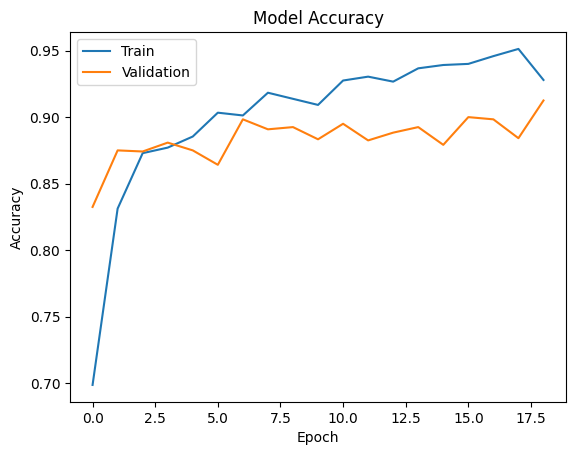

In [8]:
# Menampilkan plot akurasi pelatihan
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Display the training loss plot

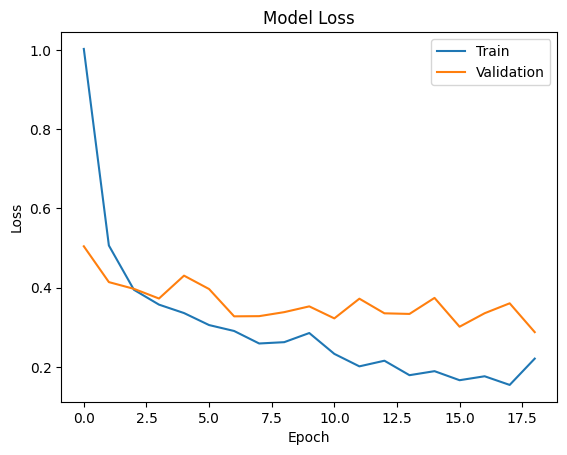

In [9]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Test Model

1/1 [==============================] - 0s 51ms/step


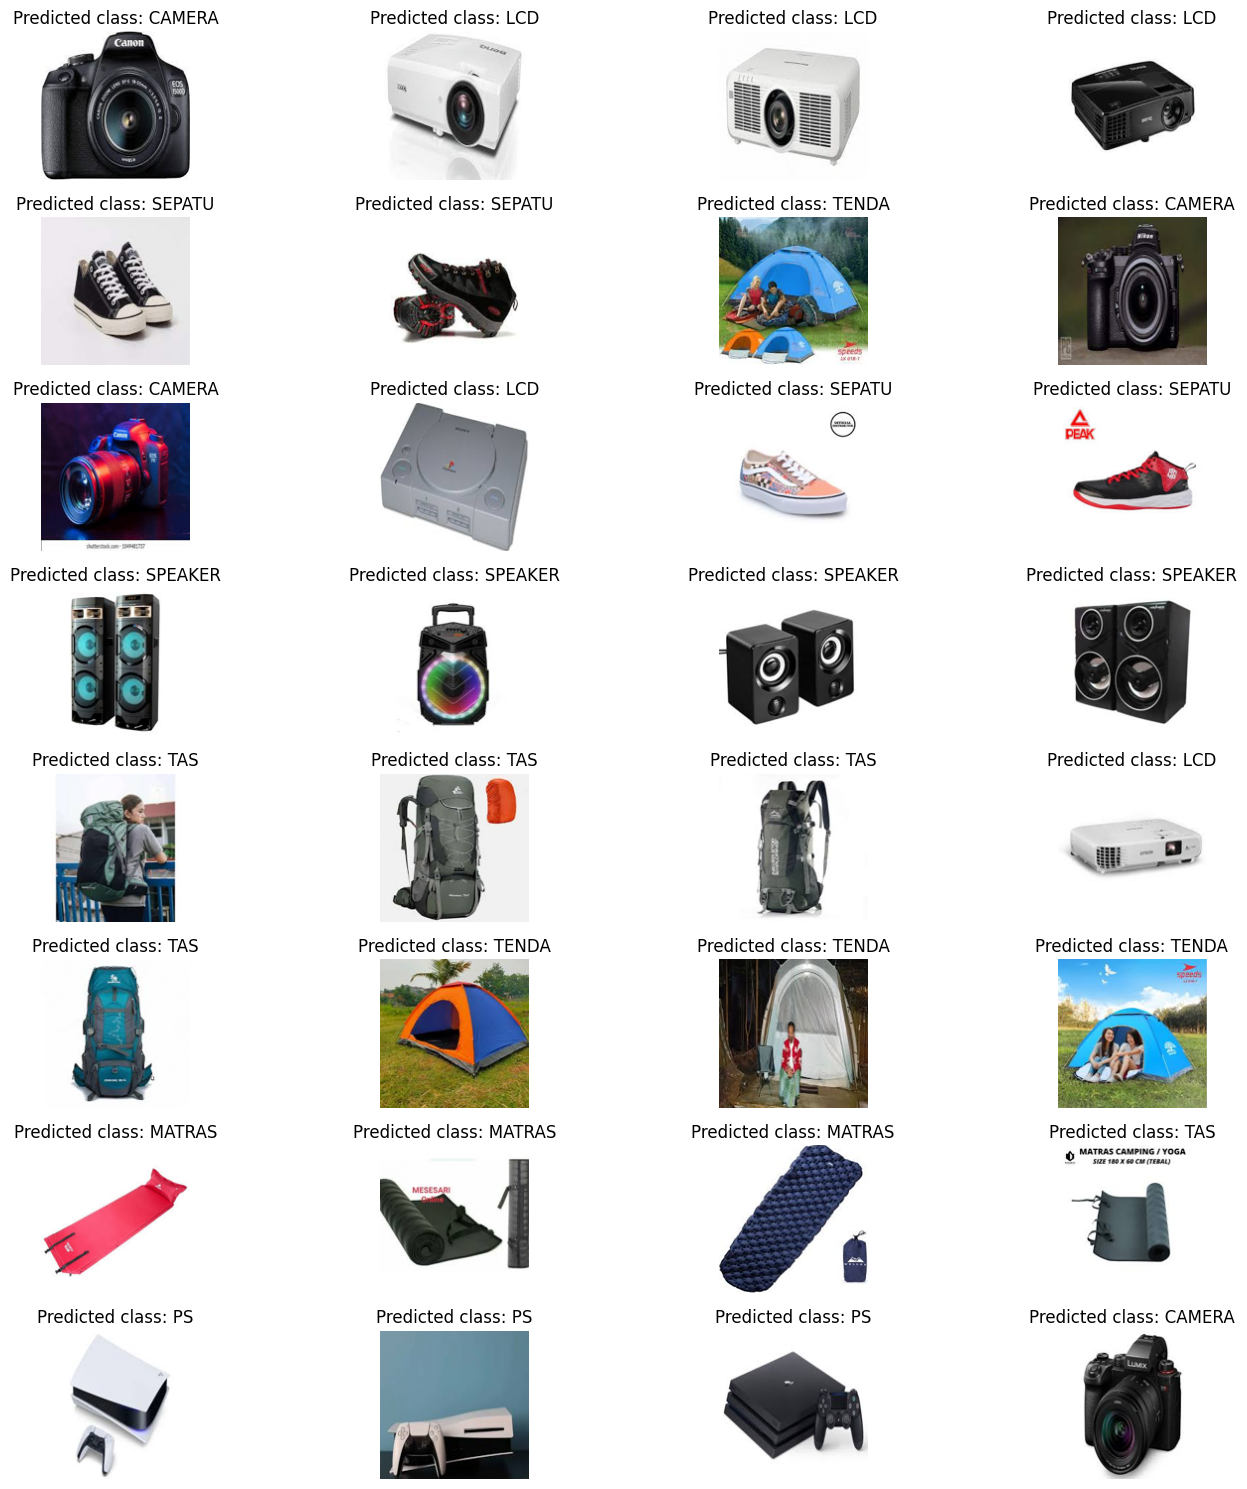

In [10]:
import os
import matplotlib.pyplot as plt

# Path ke folder yang berisi gambar-gambar yang ingin diuji
folder_path = r"D:\BANGKIT\CAPSTONE\CODING FITUR 1\tes_data"

# Daftar file gambar dalam folder
image_files = os.listdir(folder_path)

# Menghitung jumlah gambar
num_images = len(image_files)

# Mengatur jumlah kolom dalam subplot
num_cols = 4

# Menghitung jumlah baris dalam subplot
num_rows = (num_images + num_cols - 1) // num_cols

# Membuat subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Perulangan untuk setiap file gambar
for i, file in enumerate(image_files):
    # Memuat gambar
    image_path = os.path.join(folder_path, file)
    test_image = Image.open(image_path)
    test_image = test_image.resize((150, 150))  # Menyesuaikan ukuran gambar dengan ukuran input model
    test_image = np.array(test_image) / 255.0  # Normalisasi piksel gambar

    # Menambahkan dimensi batch pada gambar
    test_image = np.expand_dims(test_image, axis=0)

    # Melakukan prediksi menggunakan model
    predictions = model.predict(test_image)

    # Mendapatkan kelas prediksi
    predicted_class = np.argmax(predictions)

    # Mengubah kelas prediksi menjadi label kelas
    class_labels = train_generator.class_indices
    predicted_label = list(class_labels.keys())[list(class_labels.values()).index(predicted_class)]

    # Menampilkan gambar dan hasil prediksi pada subplot yang sesuai
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(test_image[0])
    ax.axis('off')  # Menghilangkan sumbu koordinat
    ax.set_title('Predicted class: ' + predicted_label)

# Menampilkan subplot
plt.tight_layout()
plt.show()